# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [1]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# dataset = get_dataset("/home/workspace/data/waymo/training_and_validation/*.tfrecord")
filepath = "/home/workspace/data/train/"
dataset = get_dataset(f"{filepath}*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['/home/workspace/data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


In [3]:
### create batch for display
# batch size
num_images = 15
# number of rows in plot
num_rows = 3
# Number of filenames to read in shuffle
num_files = 86

batch = dataset.shuffle(num_files, reshuffle_each_iteration=True).take(num_images)

### initial exploration of TFrecords

In [4]:
# display dataset specs
dataset.element_spec

{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 'source_id': TensorSpec(shape=(), dtype=tf.string, name=None),
 'key': TensorSpec(shape=(), dtype=tf.string, name=None),
 'filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'groundtruth_image_confidences': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_verified_neg_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_not_exhaustive_classes': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_boxes': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None),
 'groundtruth_area': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
 'groundtruth_is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_difficult': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'groundtruth_group_of': TensorSpec(shape=(None,), dtype=tf.bool, name=None),
 'groundtruth_weights': TensorSpec(shape=(None,), dtype=tf.float32, name=Non

In [5]:
# image size 640x640
for record in batch:
    print(record["original_image_spatial_shape"].numpy())

[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]
[640 640]


In [6]:
# bboxes in format [0...1] - rescale to image size
for record in batch:
    print(record["groundtruth_boxes"].numpy())

[[0.46752462 0.51481164 0.47591293 0.51744324]
 [0.5153869  0.95889837 0.608363   0.98126715]
 [0.4793676  0.07829228 0.5351252  0.10066109]
 [0.47977814 0.40910804 0.5024759  0.41524848]
 [0.47127464 0.7541579  0.5432167  0.7710003 ]
 [0.48430124 0.21217476 0.566704   0.2273066 ]
 [0.48183408 0.43487602 0.5040385  0.44277093]
 [0.46663615 0.06891655 0.5012752  0.10608825]
 [0.4736925  0.5796154  0.5220486  0.6000105 ]
 [0.45405418 0.21382165 0.47991157 0.22434814]
 [0.4870151  0.982583   0.501818   0.9911358 ]
 [0.46826476 0.4779689  0.48306766 0.48849538]
 [0.52729726 0.21506552 0.68260586 0.3671725 ]
 [0.46629104 0.27697852 0.5028049  0.2868471 ]
 [0.53277737 0.43999705 0.5853876  0.54620445]
 [0.48643935 0.25365555 0.53101265 0.2697306 ]
 [0.5113341  0.9301149  0.6086103  0.94510573]
 [0.46339765 0.4753674  0.4844368  0.49079806]
 [0.4835611  0.561194   0.49145597 0.5664573 ]
 [0.48236865 0.21637031 0.5760368  0.2424672 ]
 [0.4707319  0.50790364 0.4806005  0.5151406 ]
 [0.4672779  

## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

In [7]:
def display_images(batch):
    # color mapping of classes
    colormap = {1: [1, 0, 0], 2: [0, 1, 0], 4: [0, 0, 1]}
    # matching legend lines
    legend_lines = [Line2D([0], [0], color=colormap[1], lw=1, label="vehicles"), 
                    Line2D([0], [0], color=colormap[2], lw=1, label="pedestrians"), 
                    Line2D([0], [0], color=colormap[4], lw=1, label="bicycles")]
    # define rows/cols in figure
    if num_images % num_rows == 0:
        num_cols = num_images // num_rows
    else:
        num_cols = num_images % num_rows + 1

    # set up figure
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    fig.suptitle('Observations - Ground Truth Data', fontsize=14)

    ### for each tfrecord in batch...
    for idx, record in enumerate(batch):

        # ...get specs
        img = record["image"].numpy()
        img_shape = record["original_image_spatial_shape"].numpy()
        filename = record["filename"]
        gt_bboxes = record["groundtruth_boxes"].numpy()
        gt_classes = record["groundtruth_classes"].numpy()

        # ...get image and put in background
        curr_row = idx % num_rows
        curr_col = idx % num_cols
        axs[curr_row, curr_col].imshow(img)

        # ...add bounding boxes to the foregound
        for box, cl in zip(gt_bboxes, gt_classes):
            # get box coordinates
            y1, x1, y2, x2 = box
            # rescale to image size
            x1, x2 = img_shape[0]*x1, img_shape[0]*x2
            y1, y2 = img_shape[1]*y1, img_shape[1]*y2
            # define rectangle and color with colormap
            rec = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, facecolor='none', edgecolor=colormap[cl])
            # add rectangle to plot
            axs[curr_row, curr_col].add_patch(rec)

    # add legend and adjust layout
    axs[num_rows-1,0].legend(handles=legend_lines, loc='center', bbox_to_anchor=(0,-0.2))
    plt.tight_layout()

    # display
    plt.show()

    # save figure to png
    fig.savefig('results/data_exploratory_analysis.png')
    pass

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

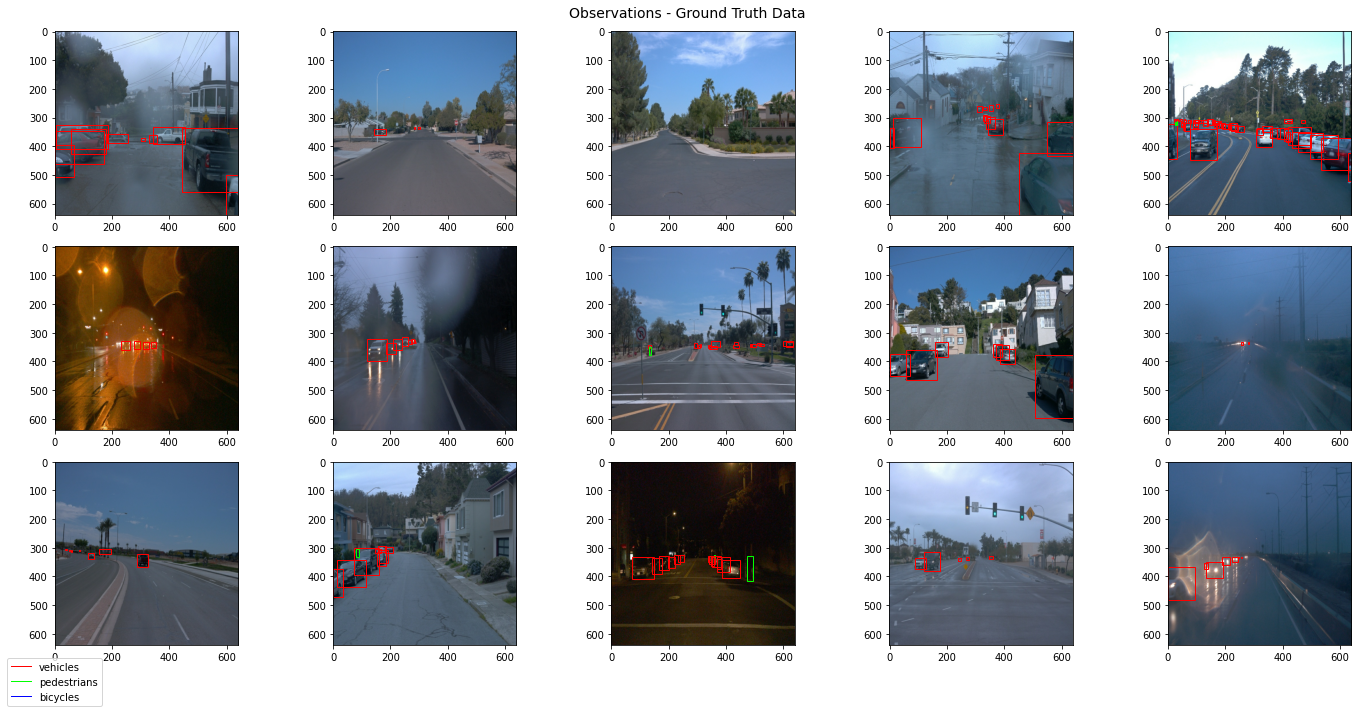

In [8]:
# Display 10 random images in training dataset
display_images(batch)

### Observations
At first glance, it becomes obvious that the class distribution in our dataset is skewed. There are a lot of vehicles, as opposed to lesser pedestrians and almost no bicycles. Model performance should be monitored closely especially for the minority classes. In order to avoid poor performance of the object detection for the minority class, one could adopt multitude of strategies such as resampling, adapting the performance metrics etc. Some general proposals can be found [here](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). The occurence of the different object types is very heterogenous across images. There might be images with vehicles only (e.g. on a highway), while there are others with more pedestrians than vehicles (e.g. on a crossroad).

The light conditions vary across the dataset, with sunny conditions (leading to brighter images with high contrast) as well as rainy/foggy conditions (leading to reflections and blurs in the images). Also, there are recordings of night drives. Image distortions can be observed as well.

## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...

In [9]:
# make array with unique object detections
for cl in dataset.take(5):
    print(np.unique(cl['groundtruth_classes'].numpy(), return_counts=True))

(array([1]), array([18]))
(array([1]), array([15]))
(array([1, 2]), array([20,  2]))
(array([1, 2]), array([51,  2]))
(array([1]), array([30]))


In [10]:
# get number and percentages of objects in each image
import pandas as pd

df = pd.DataFrame(index=[1,2,4])

for cl in dataset.take(1000):
    cl_id, counts = np.unique(cl['groundtruth_classes'].numpy(), return_counts=True)
    df_i = pd.DataFrame(index=cl_id, data=counts)
    df = pd.concat([df, df_i], axis=1)

df = df.transpose().rename(columns={1:'vehicles', 2:'pedestrians', 4:'bicycles'})

# sum of all objects in the respective image
df['obj_sum'] = df.sum(axis=1)
# percentages of all objects in respective image
df['vehicles_per'] = df['vehicles']/df['obj_sum']
df['pedestrians_per'] = df['pedestrians']/df['obj_sum']
df['bicycles_per'] = df['bicycles']/df['obj_sum']

df = df.fillna(0.0)

# df

In [11]:
df2 = pd.DataFrame()
# mean number of objects per type per image
# df2["mean_per_image"] = df[["vehicles", "pedestrians", "bicycles"]].mean()
# total number of objects per type across all given images
df2["total_across_images"] = df[["vehicles", "pedestrians", "bicycles"]].sum()
# percentage of objects per type across all given images
df2["percentage_across_images"] = df2["total_across_images"] / df2["total_across_images"].sum()

df2

,total_across_images,percentage_across_images
vehicles,17250.0,0.784162
pedestrians,4651.0,0.211428
bicycles,97.0,0.004409


### object class distribution
the plot below shows the imbalance between the objects in our dataset: for a shuffled batch, there are roughly 125x more vehicles than bicycles.

/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


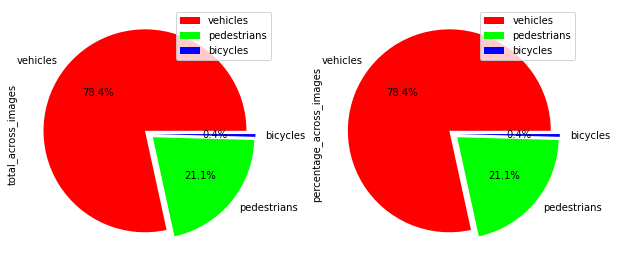

In [12]:
pieplot = df2["total_across_images"].plot.pie(subplots=True, figsize=(10,5), autopct='%0.1f%%', colors = ['#FF0000', '#00FF00', '#0000FF'], explode=(0.05, 0.05, 0.05))

# save figure
fig = pieplot[0].get_figure()
fig.savefig('results/data_exploratory_analysis_piechart.png')

### distribution of objects per class per image
The plot below displays the distribution of objects in individual images. This distribution is shifted towards the lower end, i.e. most images contain a lower number of objects, while few images contain a large number of objects.

/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/data/virtual_envs/sdc-c1-gpu-augment/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


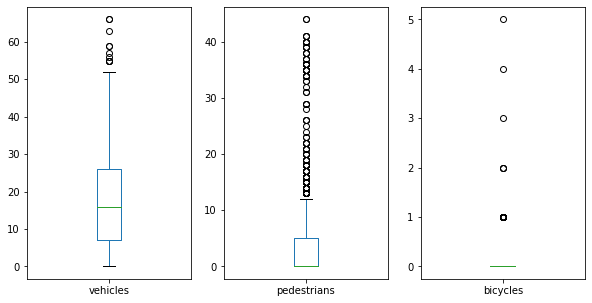

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
df["vehicles"].plot.box("vehicles", ax=ax[0], showmeans=True)
df["pedestrians"].plot.box("pedestrians", ax=ax[1], showmeans=True)
df["bicycles"].plot.box("bicycles", ax=ax[2], showmeans=True)

# save figure
fig.savefig('results/data_exploratory_analysis_box.png')

### image brightness
The plot below shows the average brightness across a set of 1000 images. The average image brightness has a very distinct peak at around 90 and a smaller peak at around 130.
Except for a small cluster of very dark images, the frequency decreases towards high and low brightness values.

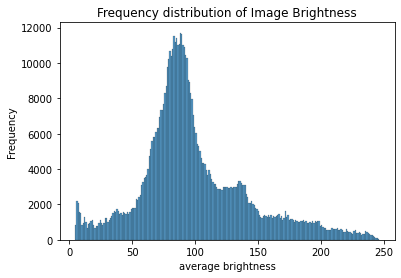

In [14]:
import seaborn as sns
from PIL import Image, ImageStat

avg_bright = []
for cl in dataset.take(1000):
    for img in cl["image"].numpy():
        image = Image.fromarray(np.uint8(img)).convert('L')
        stat = ImageStat.Stat(image)
        avg = stat.mean[0]
        avg_bright.append(avg)

#histogram plot
brightnessplot = sns.histplot(x=avg_bright)
brightnessplot.set(xlabel = 'average brightness', ylabel='Frequency', title='Frequency distribution of Image Brightness')
fig = brightnessplot.get_figure()
fig.savefig('results/data_exploratory_analysis_brightness.png') 
#avg_bright